# Predicting age, gender and ethnicity

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import models, Sequential, layers, optimizers, callbacks
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/age_gender.csv")
data = pd.DataFrame(data)
data.head(5)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Pre-process the data

In [4]:
# Turn pixels into numpy array
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
data['pixels']

0        [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...
1        [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....
2        [67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79....
3        [193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202...
4        [202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210...
                               ...                        
23700    [127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9...
23701    [23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85....
23702    [59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101...
23703    [45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140....
23704    [156.0, 161.0, 160.0, 165.0, 170.0, 173.0, 166...
Name: pixels, Length: 23705, dtype: object

In [5]:
# Scale the pixels to converge the CNN faster
data['pixels'] = data['pixels'].apply(lambda x: x/255)
data.head(5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."


In [6]:
# resize the pixels 
X = np.array(data['pixels'].tolist())

# Converting pixels from 1D to 3D, 48 is sqrt of number of pixels per picture, and one channel as images a black and white
X = np.reshape(X, (len(data),48,48,1))
X.shape


(23705, 48, 48, 1)

In [7]:
X[0,:].shape

(48, 48, 1)

## EDA

In [8]:
data.ethnicity.value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [9]:
data.gender.value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


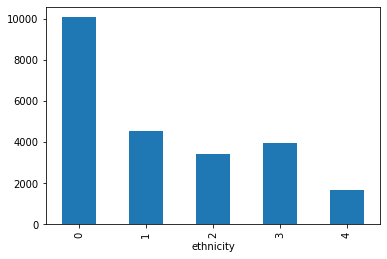

In [11]:
data.groupby('ethnicity')['img_name'].count().plot.bar();

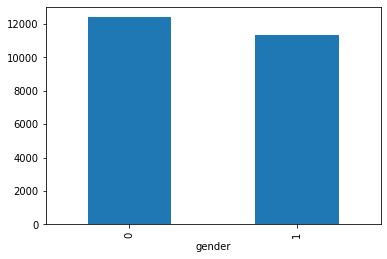

In [12]:
data.groupby('gender')['img_name'].count().plot.bar();

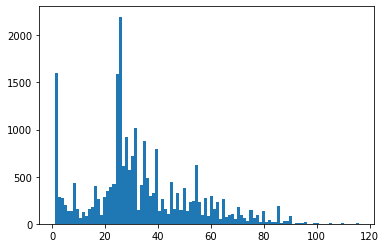

In [13]:
plt.hist(data.age, bins=100);

In [14]:
len(data.pixels.loc[data.index[1]])

2304

In [15]:
X.shape

(23705, 48, 48, 1)

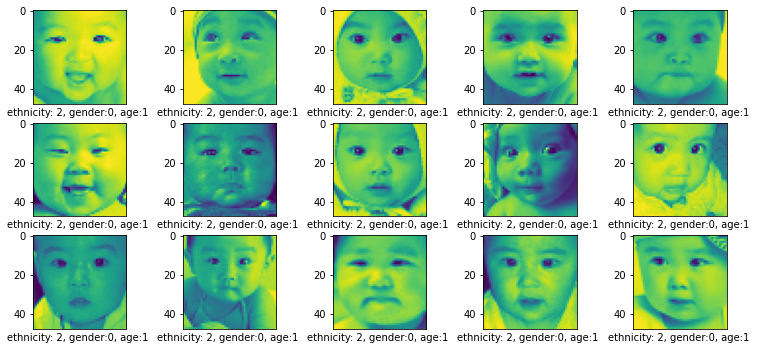

In [16]:
fig = plt.figure(figsize=(13,10))
for i in range(10,25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(f"ethnicity: {(data['ethnicity'].iloc[i])}, gender:{(data['gender'].iloc[i])}, age:{(data['age'].iloc[i])} ")
    plt.xticks(());

# Define targets and split dataset

In [17]:
y0 = data['ethnicity']
y1 = data['gender']
y2 = data['age']

# Ethnicity prediction

In [18]:
X_train, X_test, y0_train, y0_test = train_test_split(X,y0,test_size=0.3)

In [19]:
np.unique(y0)

array([0, 1, 2, 3, 4])

In [20]:
# Create model
# Architecture
model = Sequential()
model.add(layers.Conv2D(16, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Dropout(rate=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu')) # intermediate layer
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(5, activation='softmax')) # five layers for the five ethnicities
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)        0

In [21]:
# Compilation
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy']) #sparse categorical cross entropy as not OHE

In [22]:
# Fit
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y0_train,
          batch_size=16, # When batch size is too small --> no generalization
          epochs=15,    # When batch size is too large --> slow computations
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/15
726/726 [==============================] - 5s 4ms/step - loss: 1.2317 - accuracy: 0.5217 - val_loss: 0.9671 - val_accuracy: 0.6464
Epoch 2/15
726/726 [==============================] - 3s 4ms/step - loss: 0.9896 - accuracy: 0.6436 - val_loss: 0.9232 - val_accuracy: 0.6989
Epoch 3/15
726/726 [==============================] - 3s 4ms/step - loss: 0.9139 - accuracy: 0.6712 - val_loss: 0.8131 - val_accuracy: 0.7234
Epoch 4/15
726/726 [==============================] - 3s 4ms/step - loss: 0.8782 - accuracy: 0.6862 - val_loss: 0.8224 - val_accuracy: 0.7324
Epoch 5/15
726/726 [==============================] - 3s 4ms/step - loss: 0.8411 - accuracy: 0.7032 - val_loss: 0.7926 - val_accuracy: 0.7294
Epoch 6/15
726/726 [==============================] - 3s 4ms/step - loss: 0.8162 - accuracy: 0.7053 - val_loss: 0.7590 - val_accuracy: 0.7441
Epoch 7/15
726/726 [==============================] - 3s 4ms/step - loss: 0.8009 - accuracy: 0.7150 - val_loss: 0.7296 - val_accuracy: 0.7497
Epoch 

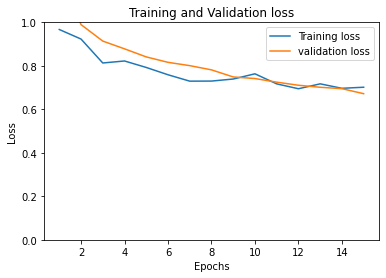

In [24]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
epochs = range(1,16)
plt.plot(epochs, val_loss, label='Training loss')
plt.plot(epochs, train_loss, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1)

plt.show()

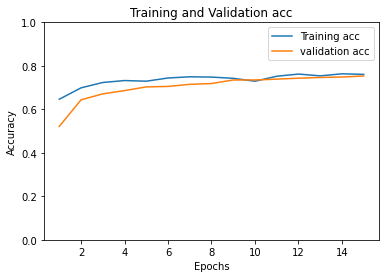

In [25]:
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
epochs = range(1,16)
plt.plot(epochs, val_acc, label='Training acc')
plt.plot(epochs, train_acc , label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

In [26]:
model.evaluate(X_test,y0_test)

223/223 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.7573


[0.6944126486778259, 0.7573115825653076]

## Gender prediction

In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X,y1,test_size=0.3)

In [28]:
# Architecture
model1 = Sequential()
model1.add(layers.Conv2D(16, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))
model1.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model1.add(layers.MaxPool2D(pool_size=(2,2))) 
model1.add(layers.Flatten())
model1.add(layers.Dense(50, activation='relu')) # intermediate layer
model1.add(layers.Dense(1, activation='sigmoid')) 
model1.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 32)        2080      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3872)              0         
                                                                 
 dense_2 (Dense)             (None, 50)               

In [29]:
model1.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy']) 

In [30]:
# Fit

history1 = model1.fit(X1_train, y1_train,
batch_size=16, # When batch size is too small --> no generalization
epochs=15,    # When batch size is too large --> slow computations,
validation_split=0.3,
callbacks=[es],
verbose=1)

Epoch 1/15
726/726 [==============================] - 4s 5ms/step - loss: 0.4599 - accuracy: 0.7787 - val_loss: 0.3776 - val_accuracy: 0.8423
Epoch 2/15
726/726 [==============================] - 3s 4ms/step - loss: 0.3396 - accuracy: 0.8477 - val_loss: 0.3854 - val_accuracy: 0.8178
Epoch 3/15
726/726 [==============================] - 3s 4ms/step - loss: 0.2926 - accuracy: 0.8674 - val_loss: 0.3322 - val_accuracy: 0.8556
Epoch 4/15
726/726 [==============================] - 3s 4ms/step - loss: 0.2629 - accuracy: 0.8846 - val_loss: 0.3179 - val_accuracy: 0.8632
Epoch 5/15
726/726 [==============================] - 3s 4ms/step - loss: 0.2436 - accuracy: 0.8930 - val_loss: 0.2691 - val_accuracy: 0.8869
Epoch 6/15
726/726 [==============================] - 3s 4ms/step - loss: 0.2274 - accuracy: 0.9025 - val_loss: 0.2844 - val_accuracy: 0.8819
Epoch 7/15
726/726 [==============================] - 3s 4ms/step - loss: 0.2039 - accuracy: 0.9142 - val_loss: 0.3093 - val_accuracy: 0.8732
Epoch 

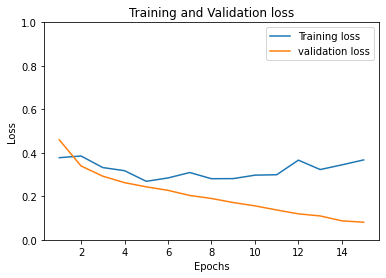

In [31]:
val_loss = history1.history['val_loss']
train_loss = history1.history['loss']
epochs = range(1,16)
plt.plot(epochs, val_loss, label='Training loss')
plt.plot(epochs, train_loss, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1)

plt.show()

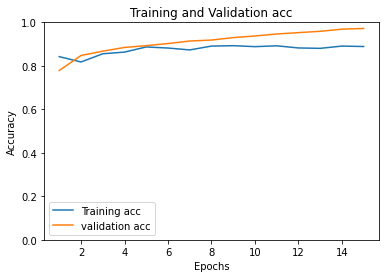

In [32]:
val_acc = history1.history['val_accuracy']
train_acc = history1.history['accuracy']
epochs = range(1,16)
plt.plot(epochs, val_acc, label='Training acc')
plt.plot(epochs, train_acc , label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

In [33]:
model1.evaluate(X1_test,y1_test)

223/223 [==============================] - 1s 3ms/step - loss: 0.2757 - accuracy: 0.8848


[0.2756984531879425, 0.8848425149917603]

## Age Prediction

In [34]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X,y2,test_size=0.3)

In [35]:
# Architecture
model2 = Sequential()
model2.add(layers.Conv2D(16, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model2.add(layers.MaxPool2D(pool_size=(2,2))) 
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(50, activation='relu')) # intermediate layer
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(1, activation='linear'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 23, 23, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 11, 11, 32)       

In [36]:
model2.compile(optimizer='adam', loss= 'mse', metrics=['mse']) 

In [37]:
# Fit
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history2 = model2.fit(X2_train, y2_train,
batch_size=16, # When batch size is too small --> no generalization
epochs=30,    # When batch size is too large --> slow computations,
validation_split=0.3,
callbacks=[es],
verbose=1)

Epoch 1/30
726/726 [==============================] - 4s 5ms/step - loss: 398.6200 - mse: 398.6200 - val_loss: 373.0602 - val_mse: 373.0602
Epoch 2/30
726/726 [==============================] - 3s 4ms/step - loss: 269.3135 - mse: 269.3135 - val_loss: 317.5767 - val_mse: 317.5767
Epoch 3/30
726/726 [==============================] - 3s 4ms/step - loss: 241.1488 - mse: 241.1488 - val_loss: 208.2411 - val_mse: 208.2411
Epoch 4/30
726/726 [==============================] - 3s 4ms/step - loss: 226.6891 - mse: 226.6891 - val_loss: 199.7469 - val_mse: 199.7469
Epoch 5/30
726/726 [==============================] - 3s 4ms/step - loss: 213.7905 - mse: 213.7905 - val_loss: 214.3941 - val_mse: 214.3941
Epoch 6/30
726/726 [==============================] - 3s 4ms/step - loss: 202.9674 - mse: 202.9674 - val_loss: 187.9592 - val_mse: 187.9592
Epoch 7/30
726/726 [==============================] - 3s 4ms/step - loss: 192.8484 - mse: 192.8484 - val_loss: 219.4144 - val_mse: 219.4144
Epoch 8/30
726/726 [

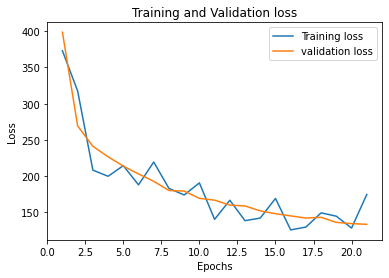

In [42]:
val_loss = history2.history['val_loss']
train_loss = history2.history['loss']
epochs = range(1,22)
plt.plot(epochs, val_loss, label='Training loss')
plt.plot(epochs, train_loss, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

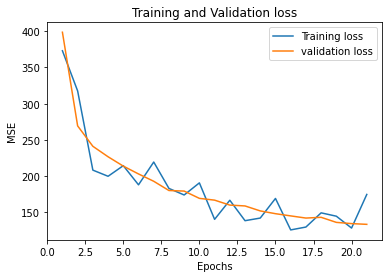

In [43]:
val_mse = history2.history['val_mse']
train_mse = history2.history['mse']
epochs = range(1,22)
plt.plot(epochs, val_mse, label='Training loss')
plt.plot(epochs, train_mse, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [44]:
model2.evaluate(X2_test,y2_test)

223/223 [==============================] - 1s 3ms/step - loss: 123.0310 - mse: 123.0310


[123.031005859375, 123.031005859375]

In [48]:
predicted_ages = np.squeeze(model2.predict(X2_test))

rmse = np.sqrt(model2.evaluate(X2_test))
print(f"RMSE:{rmse}")

r2 = r2_score(y2_test, predicted_ages)
print(f"r2 score:{r2}")

223/223 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
RMSE:[0. 0.]
r2 score:0.6891707894240274
